## AlekseevDP (DSU-4, TSML-4)_HW #2_Elementary methods TS

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения, почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

## Возьмем ряд изменения среднемесячной температуры ("Mean monthly air temperature (Deg. F) Nottingham Castle")

In [2]:
ser = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

## Зададим функцию для проведения теста Дики-Фуллера

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## Зададим функцию вывода коррелограмм

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## Для проверки ряда на стационарность сделаем тест Дики-Фуллера и посмотрим на коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


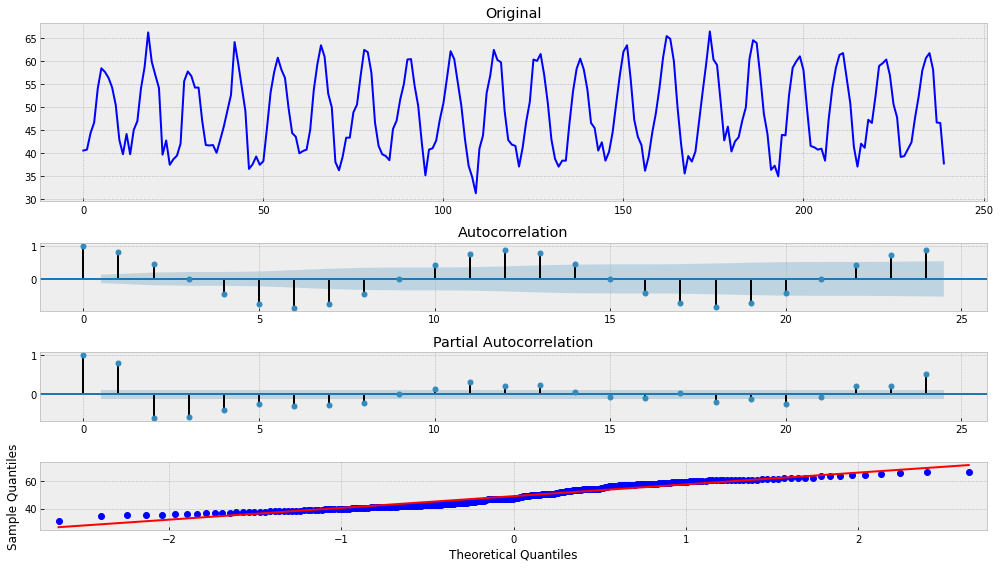

In [5]:
tsplot(ser)

## Мы видим, что p-value меньше 0.05, но присутствует сезонность, т.е. ряд не является стационарным. Попробуем сделать его приближение моделями класса MA (Moving Average). Для начала применим "обычные"методы: скользящее среднее (MA), взвешенное скользящее среднее (WMA) и экспоненциальное скользящее среднее (EMA).

In [6]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [7]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [8]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

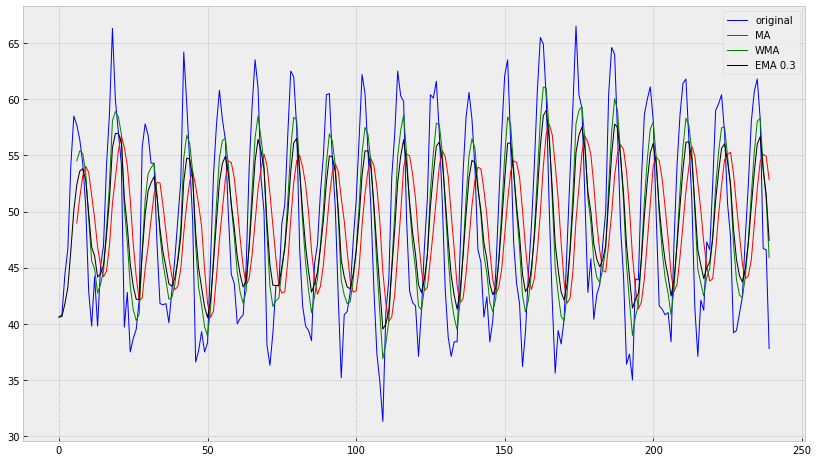

In [9]:
ema = exponential_moving_average(ser, 0.3)
wma = weighted_moving_average(ser, 7, [1,1,2,3,5,8,13])
ma = moving_average(ser, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ser, color='blue', linewidth='1', label='original')
    plt.plot(ma, color='red', linewidth='1', label='MA')
    plt.plot(wma, color='green', linewidth='1', label='WMA')
    plt.plot(ema, color='black', linewidth='1', label='EMA 0.3')
    plt.legend()

## Мы видим, что приближение происходит, но в недостаточной "амплитуде". Попробуем применить разные значения "альфа" для экспоненциального сглаживания (EMA).
Параметр "альфа" называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше "альфа", тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд.

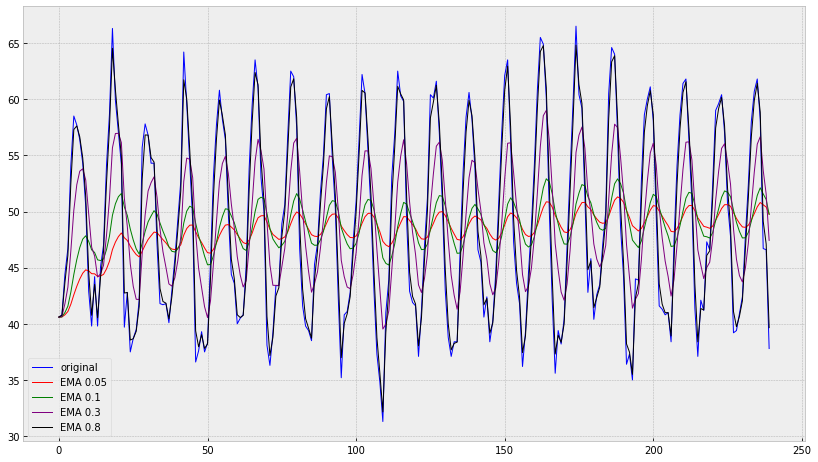

In [10]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ser, color='blue', linewidth='1', label='original')
    for i in range(len(alphas)):
        ser_ema = exponential_moving_average(ser, alphas[i])
        plt.plot(ser_ema, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

## Мы видим, что лучше всего приближение EMA происходит при высоком "альфа"=0.8, т.е. когда сглаживание ряда минимально. Попробуем теперь применить тройное экспоненциальное сглаживание (TEMA, или метод Хольта-Винтерса), т.к. в ряде присутствует ярко выраженная сезонность. [Хотя можно было бы остановиться и на обычном EMA с высоким значением "альфа", т.к. выбранный ряд достаточно простой для прогнозирования].

In [11]:
# функция расчета тренда
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [12]:
# функция расчета сезонной компоненты
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [13]:
# функция расчета тройного экспоненциального сглаживания
def triple_exponential_smoothing(ser_tma, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(ser_tma, slen)
    for i in range(len(ser_tma)+n_preds):
        if i == 0: # initial values
            smooth = ser_tma[0]
            trend = initial_trend(ser_tma, slen)
            result.append(ser_tma[0])
            continue
        if i >= len(ser_tma): # we are forecasting
            m = i - len(ser_tma) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = ser_tma[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [14]:
# функция отображения графика TEMA при заданных значениях альфа, бета и гамма
def plot_tema(alpha, beta, gamma, ser_tema=ser, ser_to_plot=ser, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='1', label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

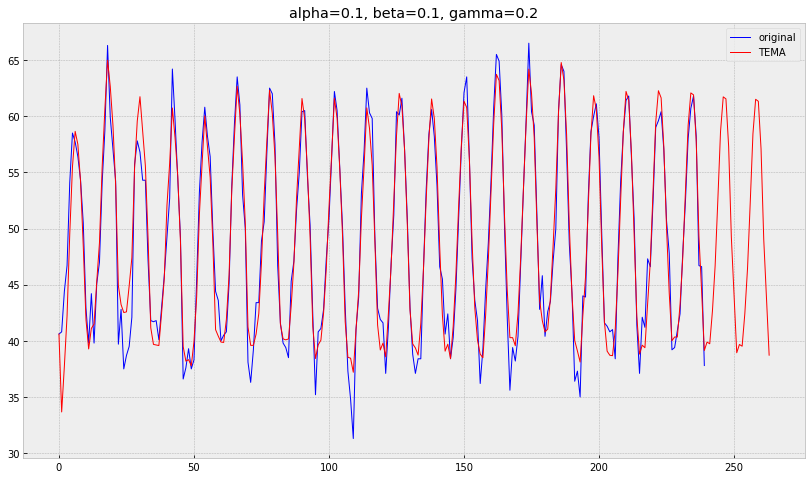

In [15]:
plot_tema(0.1, 0.1, 0.2)

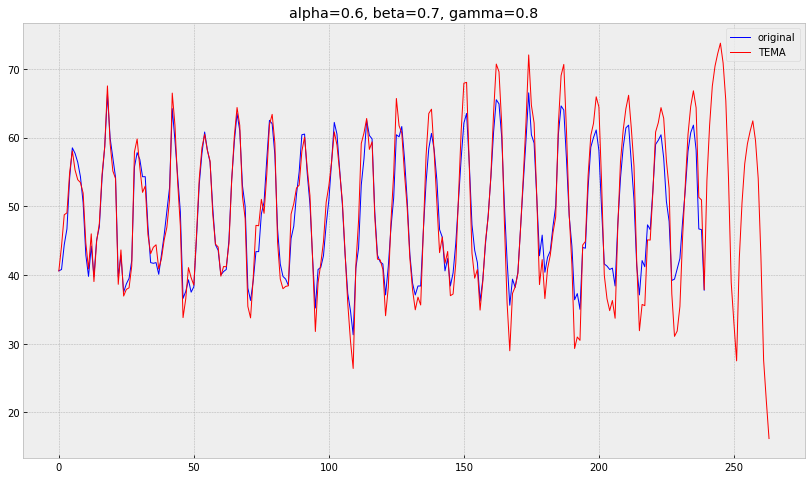

In [16]:
plot_tema(0.6, 0.7, 0.8)

## Мы видим, что результаты приближения в TEMA получились такими же (а при больших альфа, бета и гамма - хуже), чем при "обычном" EMA c высоким коэфф-том альфа (0.8). Попробуем оценить качество предсказаний при использовании TEMA (с использованием метрики RMSE) и подобрать оптимальные параметры альфа, бета и гамма.

In [17]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [18]:
ser = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

In [19]:
len(ser)

240

In [20]:
train, test, val = ser[:190], ser[190:230], ser[230:]

In [21]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [22]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [23]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.20928133948977
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.44089208e-07,  1.31716860e-04, -7.10542736e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 32
     njev: 45
   status: 0
  success: True
        x: array([0.66513166, 0.00475928, 0.12797004])


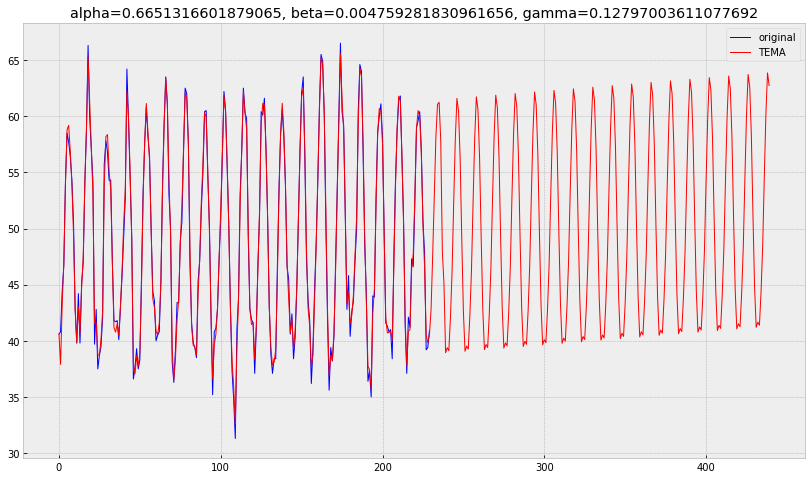

In [24]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser[:230], n_preds=len(test)*5)

In [25]:
# У нас уже есть функция MSE, теперь можем рассчитать метрику RMSE на найденных оптимальных значениях альфа, бета и гамма.
# Для этого нужно извлечь квадратный корень из MSE
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

2.0516533185433086


## Попробуем напоследок для случая с предсказанием исходного (нестационарного) ряда сделать кросс-валидацию на TEMA.

In [39]:
train, val = ser[:230], ser[230:]

In [40]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [41]:
opt = minimize(mse_cross_val, x0=[0,0,0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

73.87701326551462------------
73.87685936025798------------
73.87701326551462------------
73.87700044665243------------
12.084973761783095------------
12.0849736648926------------
12.084986005916676------------
12.084973761783095------------
12.080590046087268------------
12.0805901430169------------
12.080602285767094------------
12.08059004607072------------
12.063038045819438------------
12.063038142896543------------
12.063050268303195------------
12.063038045738061------------
11.992634902437295------------
11.99263499981557------------
11.99264706479856------------
11.992634902114062------------
11.715654979714662------------
11.715655072386445------------
11.715666965646117------------
11.715654978450388------------
10.836975019568056------------
10.836975064061974------------
10.83698488850383------------
10.83697501118377------------
11.13654481975812------------
11.136544761746885------------
11.136551485132285------------
11.136544859984838------------
10.750196580842521----

In [42]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 5.336865460459241
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.57252030e-06, -1.14575016e-05,  6.21724894e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 244
      nit: 32
     njev: 61
   status: 0
  success: True
        x: array([0.01755653, 0.00341841, 0.25818589])


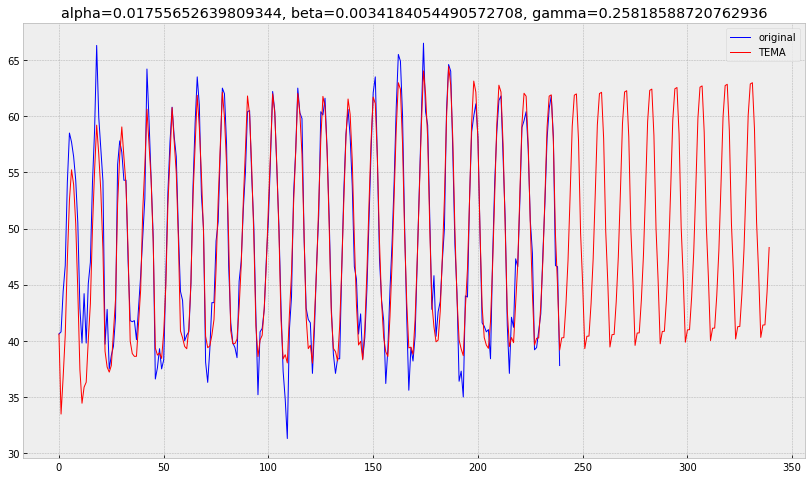

In [43]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser, n_preds=len(val)*10)

In [44]:
# рассчитаем RMSE на кросс-валидации
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

82.51965721185181


## RMSE на кросс-валидации (82.52) получилась гораздо выше, чем без кросс-валидации (2.05).

## Общий вывод по предсказаниям нестационарного ряда: Мы видим, что использование TEMA позволило хорошо предсказать сезонность, но по всей видимости модель переобучилась на тренировочных данных.  Наилучший результат визуально показало "одинарное" экспоненциальное сглаживание (EMA) c высоким "альфа" (коэфф-том сглаживания), равным 0.8. 

## Попробуем теперь сделать ряд стационарным, затем применить к нему TEMA и рассчитать RMSE.

In [48]:
ser = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

In [49]:
# Применим преобразование Бокса-Кокса и дифференцирование с лагом 12 месяцев
ser_2 = boxcox(ser, 0)

In [50]:
ser_2 = np.diff(ser_2, 12)

Results of Dickey-Fuller Test:
Test Statistic                -1.513025e+01
p-value                        7.248952e-28
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


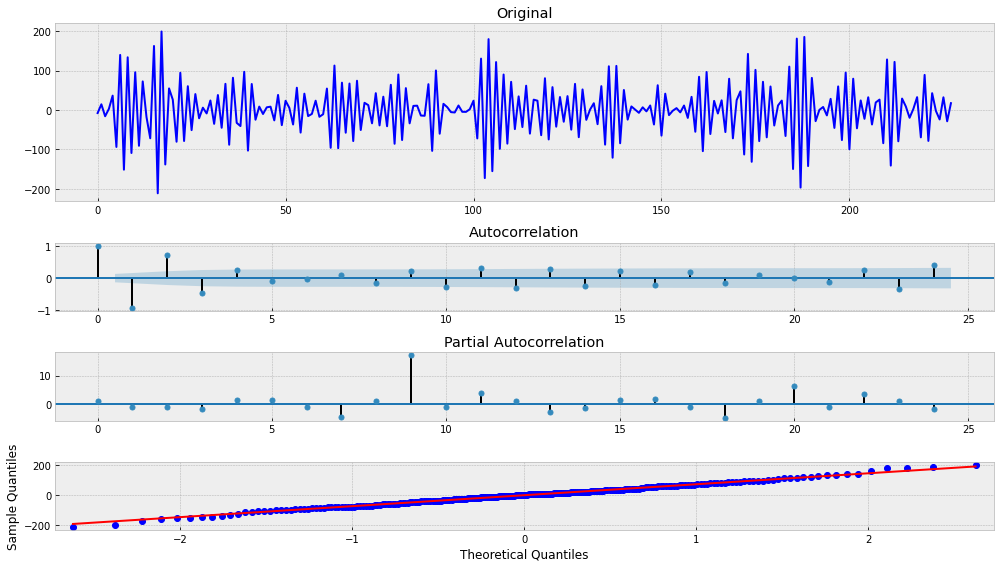

In [51]:
tsplot(ser_2)

## P-value близко к нулю, ушли тренд и сезонность. Ряд стал стационарным.

In [52]:
len(ser_2)

228

In [53]:
train, test, val = ser_2[:190], ser_2[190:220], ser_2[220:]

In [54]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [55]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4228.005296072054
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([93.6493052 , -0.35106495,  7.16017894])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 932
      nit: 167
     njev: 233
   status: 0
  success: True
        x: array([2.55594166e-04, 1.00000000e+00, 8.63571071e-02])


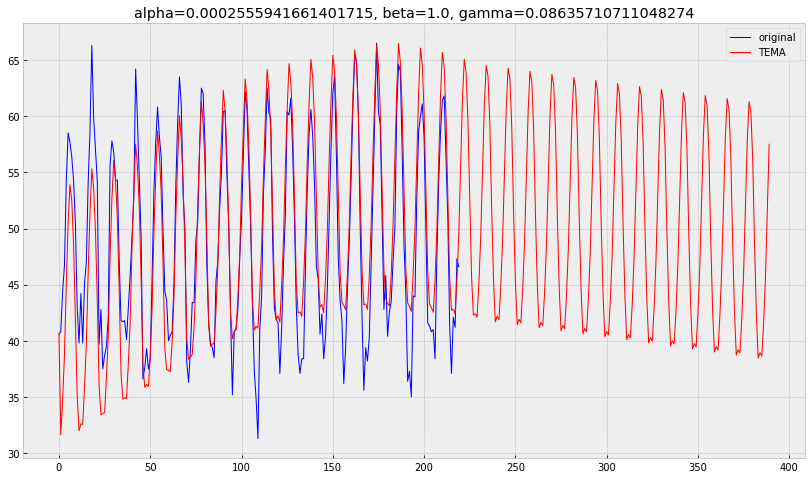

In [56]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=ser[:220], n_preds=len(test)*5)

In [57]:
# рассчитаем RMSE на TEMA со стационарным рядом
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

65.02311355258263


## Мы видим, что RMSE немного уменьшилась по сравнению с кросс-валидацией/TEMA(82.52), но всё равно гораздо больше, чем в случаях предсказаний на нестационарном ряде без кросс-валидации(2.05). А также появились тренды, которых не было на фактических данных. Можно сделать вывод, что TEMA не очень хорошо подошел для предсказания значений стационарного ряда (приведение ряда к стационарности не требовалось).